# Prophet Model with Airline Passengers dataset

**Using the airline passengers dataset, this session looks more closely at multiplicative seasonality, dealing with outliers and non-daily data. The data frequency is the start of every month, i.e. 'MS'.**

**NOTE: For Prophet model based on daily data and additive seasonality, see the Rossman notebook.**

In [1]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


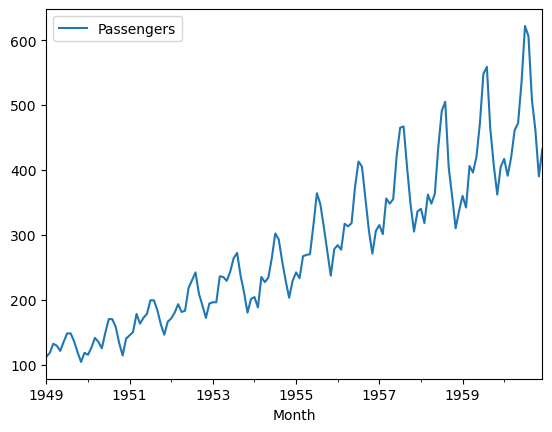

In [4]:
df.plot();

In [5]:
# Rename Passengers column

df.columns = ['y']

In [6]:
# Add ds column

df['ds'] = df.index

In [7]:
# Starts 1949-01-01

df.head()

,y,ds
Month,,
1949-01-01,112,1949-01-01
1949-02-01,118,1949-02-01
1949-03-01,132,1949-03-01
1949-04-01,129,1949-04-01
1949-05-01,121,1949-05-01


In [8]:
# Ends 1960-12-01

df.tail()

,y,ds
Month,,
1960-08-01,606,1960-08-01
1960-09-01,508,1960-09-01
1960-10-01,461,1960-10-01
1960-11-01,390,1960-11-01
1960-12-01,432,1960-12-01


## Build basic model

In [9]:
m = Prophet()

In [10]:
m.fit(df)

07:03:58 - cmdstanpy - INFO - Chain [1] start processing
07:03:58 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# 1 year forecast

future = m.make_future_dataframe(periods=12, freq='MS')

In [12]:
# See last date is one year after end of dataset

future.tail()

,ds
151,1961-08-01
152,1961-09-01
153,1961-10-01
154,1961-11-01
155,1961-12-01


In [13]:
forecast = m.predict(future)

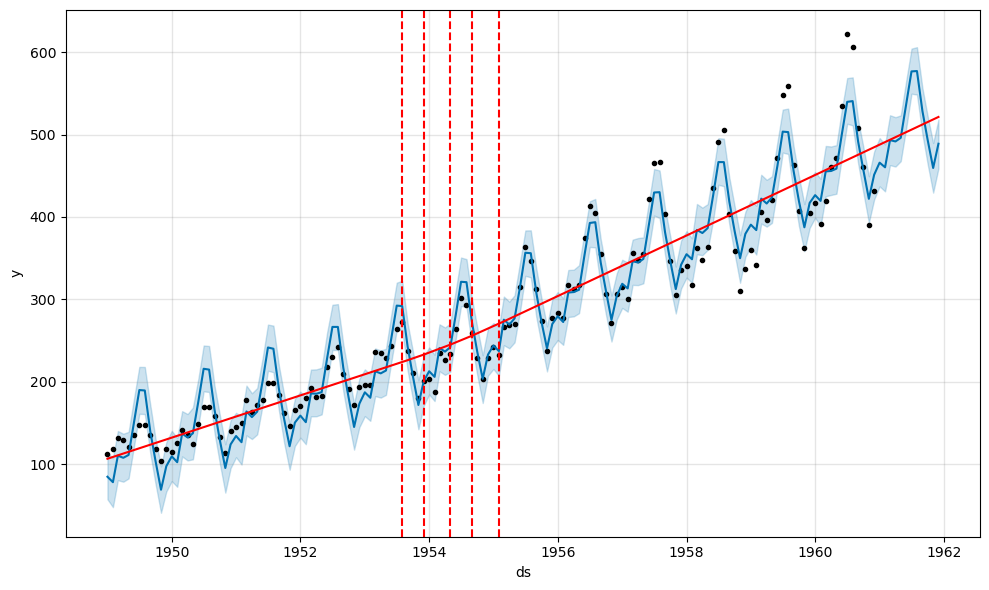

In [14]:
# Plot predictions with trend line & change points

fig = m.plot(forecast);

a = add_changepoints_to_plot(fig.gca(), m, forecast)

**This looks fairly good but notice how it overestimates at the beginning and underestimates at the end. It is unable to model the seasonal component increasing in magnitude over time. Remember that the default mode settings are 'additive'.**

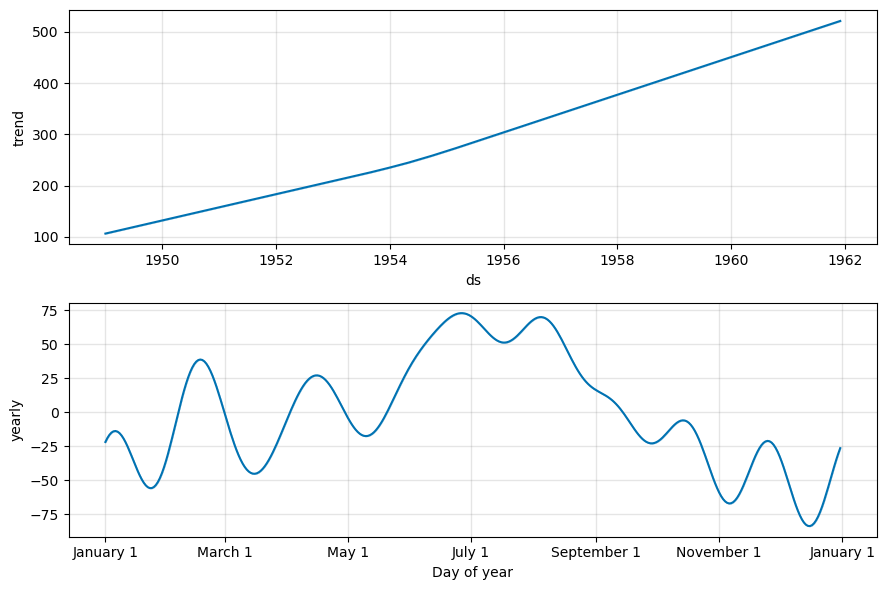

In [15]:
# Plot model components

m.plot_components(forecast);

**In the middle, the trend increases slightly.**

**In the yearly seasonality component, there is an increase over the summer months, which makes sense.**

## Build model with multiplicative seasonality

**We know that the model automatically uses 'additive' mode for its components, but using multiplicative seasonality should account for the increasing magnitude.**

In [16]:
m2 = Prophet(seasonality_mode='multiplicative')

In [17]:
m2.fit(df)

07:12:04 - cmdstanpy - INFO - Chain [1] start processing
07:12:04 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = m2.make_future_dataframe(periods=12, freq='MS')

In [19]:
forecast = m2.predict(future)

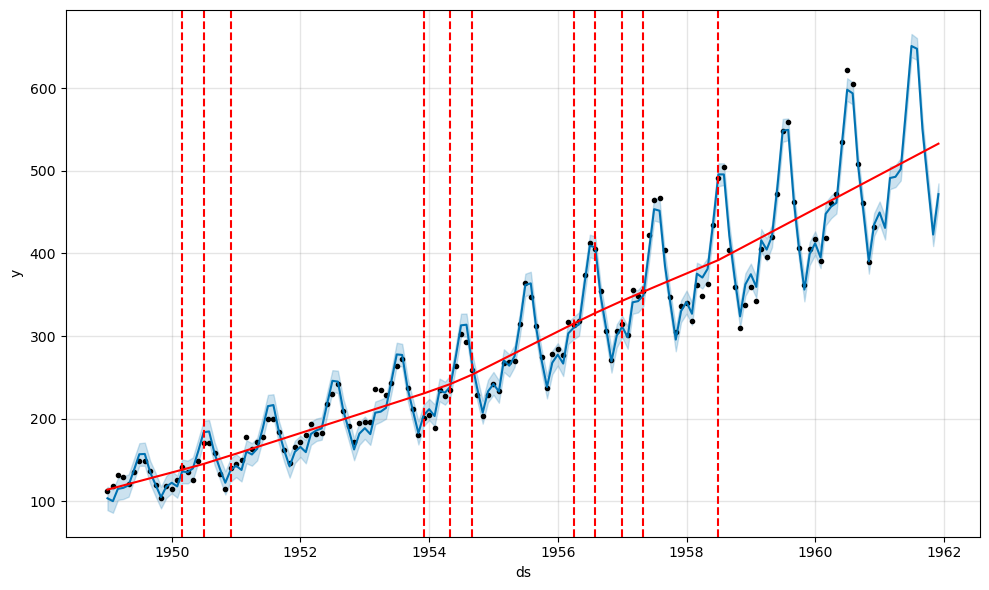

In [20]:
# Plot predictions with trend line & change points

fig = m2.plot(forecast);

a = add_changepoints_to_plot(fig.gca(), m2, forecast)

**Much better! The predictions (dark blue line) matches the peaks and troughs better. The change points, however, are not very sensible. You could try logistic growth instead of linear.**

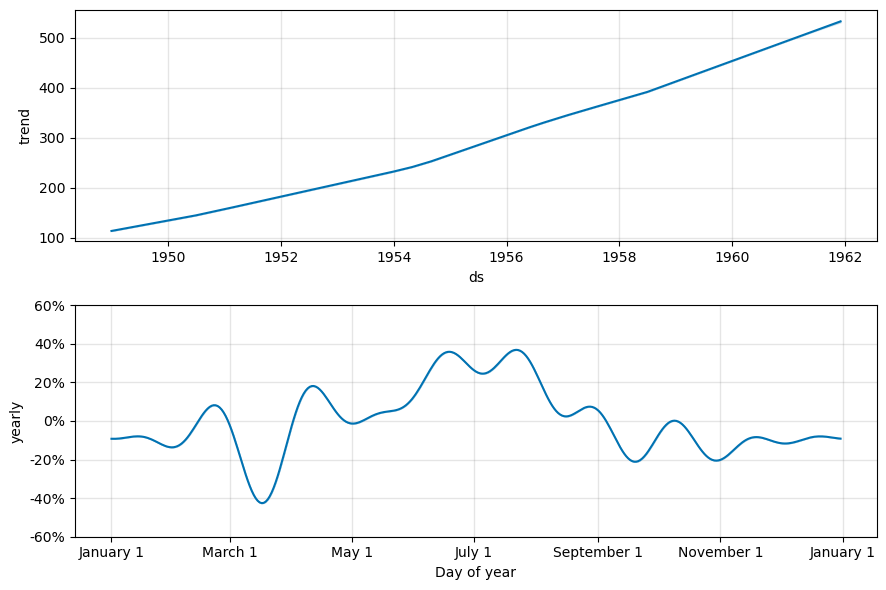

In [21]:
# Plot model components

m2.plot_components(forecast);

**The trend looks the same, but you can see the yearly seasonality has changed. You still get peaks in the summer though.**

## Log transformation of time series

**One way to avoid using multiplicative seasonality is to log-transform the time series beforehand.**

In [22]:
logdf = df.copy()

logdf['y'] = np.log(logdf['y'])

In [23]:
m3 = Prophet()

In [24]:
m3.fit(logdf)

07:18:00 - cmdstanpy - INFO - Chain [1] start processing
07:18:00 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future = m3.make_future_dataframe(periods=12, freq='MS')

In [26]:
forecast = m3.predict(future)

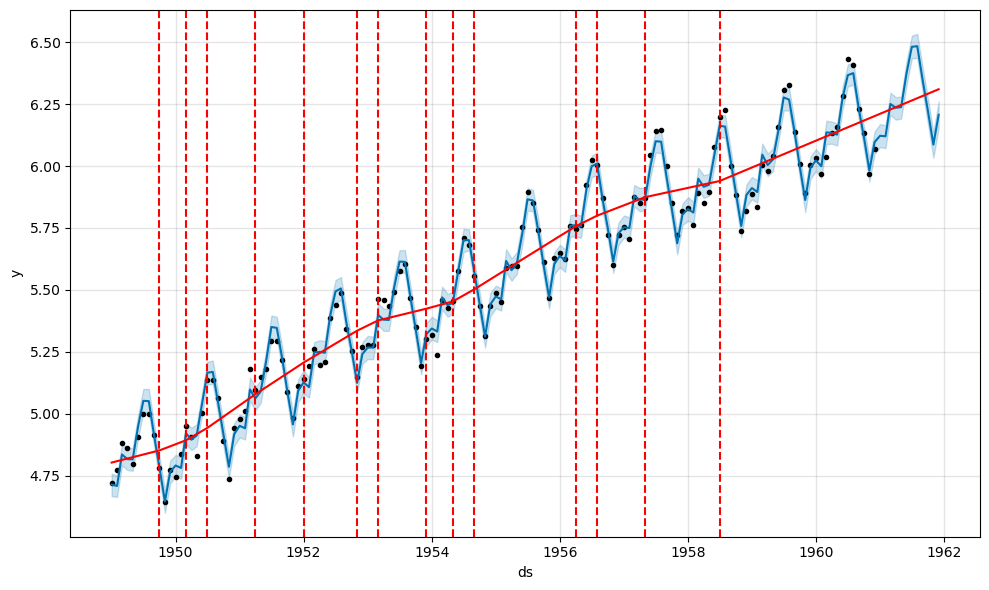

In [27]:
# Plot predictions with trend line & change points

fig = m3.plot(forecast);

a = add_changepoints_to_plot(fig.gca(), m3, forecast)

**This model seems a bit too sensitive with its change points, but the predictions match the true values well. It has no problem with the seasonality thanks to the log-transformation.**

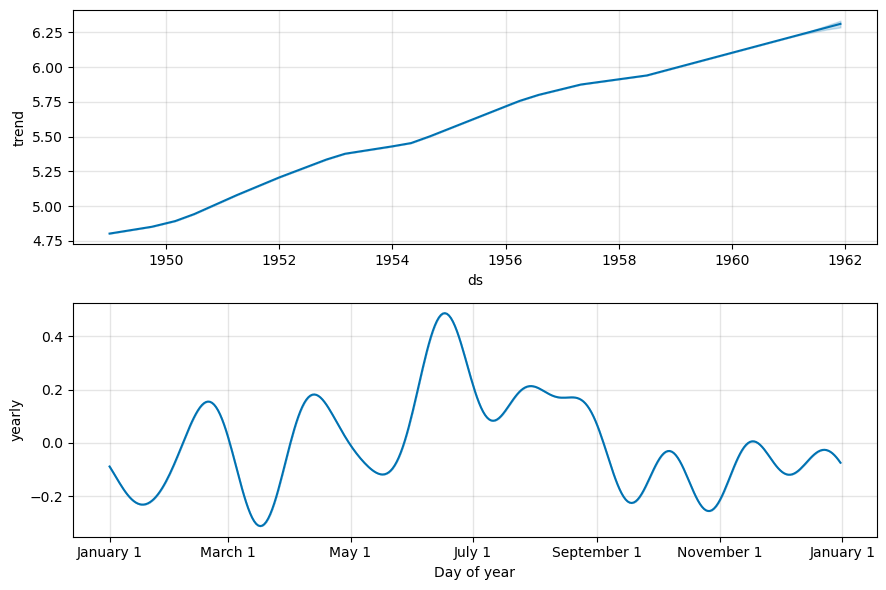

In [28]:
# Plot model components

m3.plot_components(forecast);

**The trend is much the same, and you still get peaks in the summer for seasonality.**

## Dealing with outliers

**For this exercise, you need to introduce fake outliers to the dataset, both uncharacteristically high and low. Use multiplicative seasonality instead of log-trasformation.**

In [29]:
# Introduce two outliers (large value in Jan, low value in June)

df.loc['1955-01-01', 'y'] = 600

df.loc['1957-06-01', 'y'] = 1

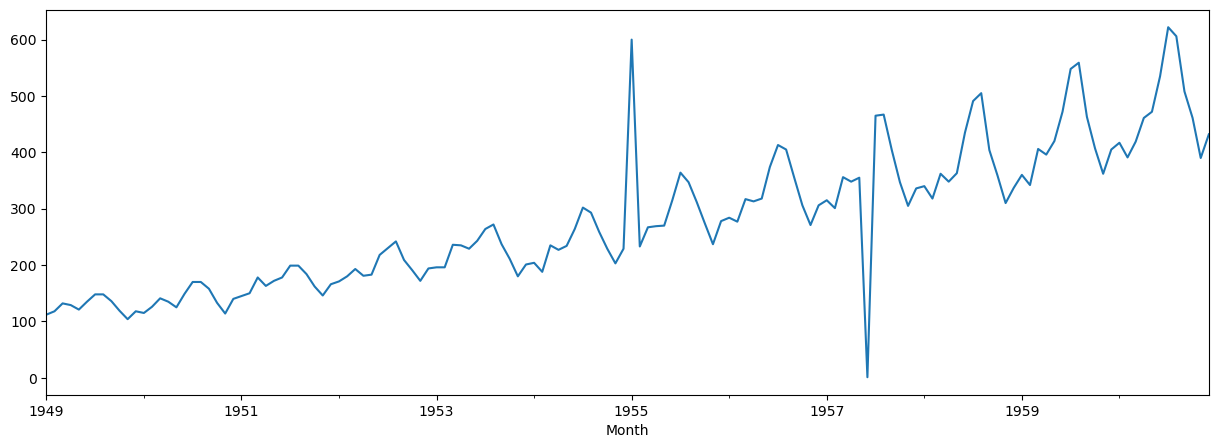

In [30]:
df['y'].plot(figsize=(15, 5));

07:24:19 - cmdstanpy - INFO - Chain [1] start processing
07:24:19 - cmdstanpy - INFO - Chain [1] done processing


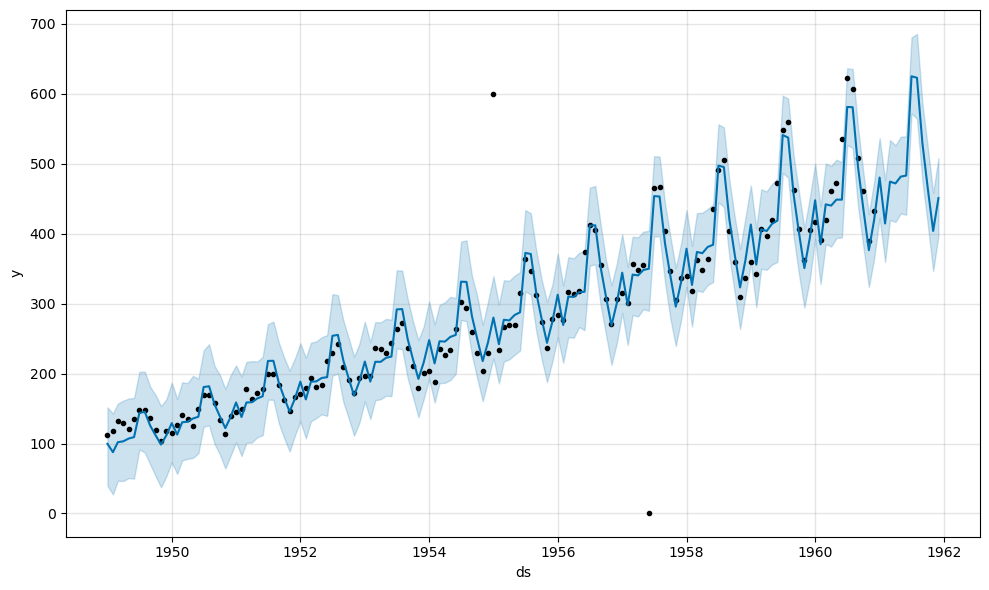

In [31]:
m = Prophet(seasonality_mode='multiplicative')

m.fit(df)

future = m.make_future_dataframe(periods=12, freq='MS')

forecast = m.predict(future)

m.plot(forecast);

**Notice the wide confidence intervals, even though the predictions fit quite well. This is due to the outliers, making the model less confident in its predictions.**

**Prophet is a continuous model, i.e. missing data is not an issue. The best way to deal with outliers is to simply remove them.**

In [32]:
df2 = df[~df.index.isin(['1955-01-01', '1957-06-01'])]

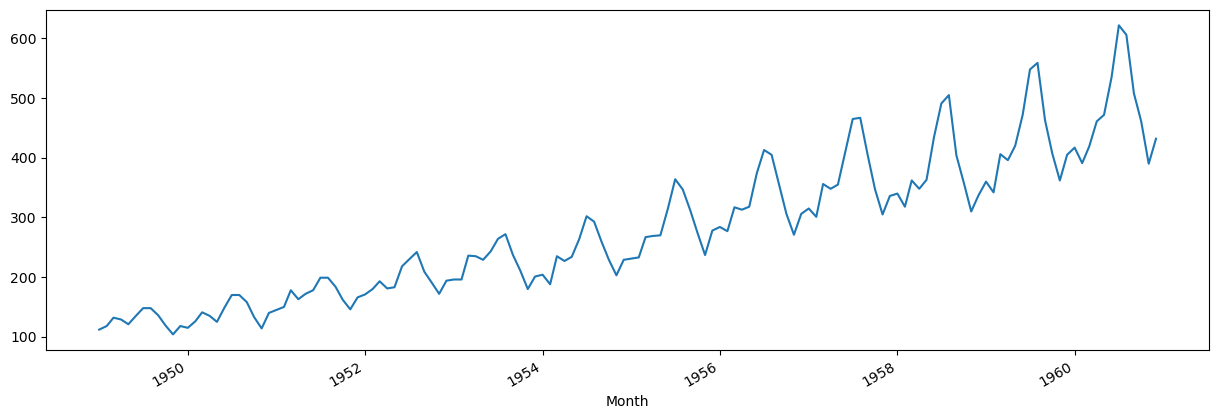

In [33]:
# i.e. same as before

df2['y'].plot(figsize=(15, 5));

07:27:53 - cmdstanpy - INFO - Chain [1] start processing
07:27:53 - cmdstanpy - INFO - Chain [1] done processing


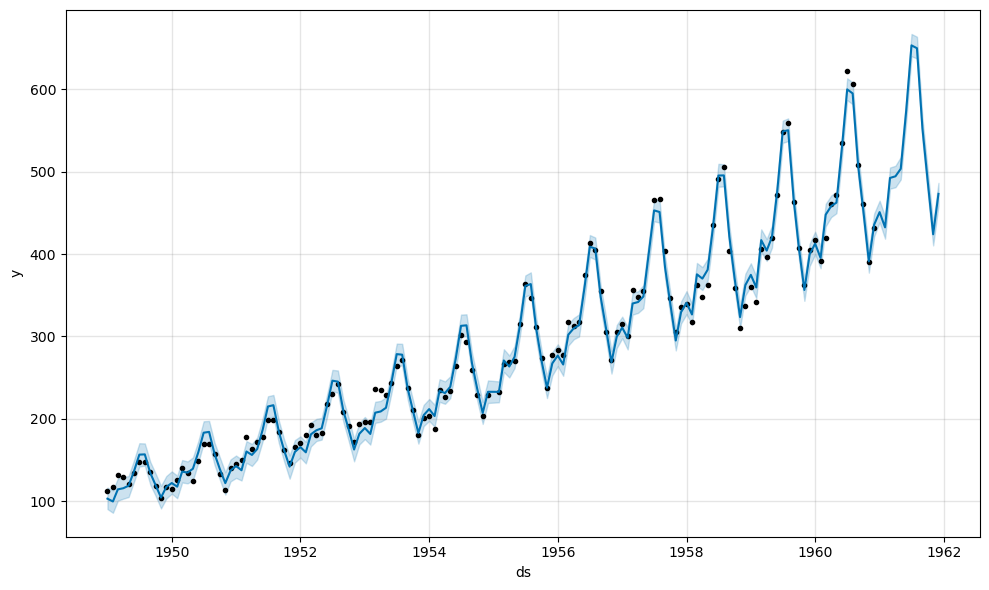

In [34]:
# Re-buill model

m = Prophet(seasonality_mode='multiplicative')

m.fit(df2)

future = m.make_future_dataframe(periods=12, freq='MS')

forecast = m.predict(future)

m.plot(forecast);

**Once again, we get good predictions, and now the confidence intervals are much tighter since the model does not have to account for deviations in the data.**